In [1]:
import geopandas as gpd
gdf = gpd.read_file('/home/yamanishi/project/trip_recommend/model/popularity_final/data/japan_ver84/japan_ver84/japan_ver84.shp')
gdf.head()

/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/study_group/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


JCODE  KEN  SICHO   GUN SEIREI SIKUCHOSON                   CITY_ENG  \
0  01101  北海道  石狩振興局  None    札幌市        中央区       Sapporo-shi, Chuo-ku   
1  01102  北海道  石狩振興局  None    札幌市         北区       Sapporo-shi, Kita-ku   
2  01103  北海道  石狩振興局  None    札幌市         東区    Sapporo-shi, Higashi-ku   
3  01104  北海道  石狩振興局  None    札幌市        白石区  Sapporo-shi, Shiroishi-ku   
4  01105  北海道  石狩振興局  None    札幌市        豊平区   Sapporo-shi, Toyohira-ku   

    P_NUM   H_NUM  Shape_Leng  Shape_Area  \
0  239944  146024    0.542590    0.005128   
1  286054  153908    0.567773    0.007031   
2  262298  144421    0.397203    0.006289   
3  214050  124710    0.308211    0.003815   
4  224435  129875    0.428316    0.005101   

                                            geometry  
0  POLYGON ((141.34233 43.06682, 141.35520 43.068...  
1  POLYGON ((141.40839 43.18395, 141.40427 43.182...  
2  POLYGON ((141.44698 43.15513, 141.44860 43.153...  
3  POLYGON ((141.46569 43.10000, 141.46812 43.097...  
4  POLYGON ((141.38479 43.04660, 141.38558 43.047...

import

In [2]:
import os

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import shapely
from tqdm import tqdm
from collections import defaultdict
import geopandas as gpd
from pysal.lib import weights
from splot.esda import lisa_cluster
from matplotlib.pyplot import Axes

ModuleNotFoundError: No module named 'seaborn'

In [2]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
tfidf_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')
tfidf_topk_index = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_topk_index.npy')
tfidf_top_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')

In [ ]:
d = defaultdict(list)
for index in tqdm(range(len(df_exp))):
    lat = df_exp.loc[index, 'latitude']
    lon = df_exp.loc[index, 'longitude']
    count = [0]*len(gdf)
    contain=gdf['geometry'].contains(shapely.geometry.point.Point(lon, lat))
    spot_name = df_exp.loc[index, 'spot_name']
    try:
        city_index = list(contain.values).index(True)
        d[city_index].append(index)
    except ValueError:
        continue

  8%|▊         | 3238/42852 [00:02<00:35, 1112.56it/s]


KeyboardInterrupt: 

In [ ]:
with open('/home/yamanishi/project/trip_recommend/model/popularity_final/data/district_to_spot.pkl', 'wb') as f:
    pickle.dump(d, f)

In [ ]:
import pickle
with open('/home/yamanishi/project/trip_recommend/model/popularity_final/data/district_to_spot.pkl', 'rb') as f:
    district_to_spot = pickle.load(f)

In [ ]:
from shapely.geometry import Point
def point_from_lon_lat(df):
    return Point(df['longitude'], df['latitude'])

df_exp['geometry'] = df_exp.progress_apply(point_from_lon_lat, axis=1)

 99%|█████████▉| 42626/42852 [00:02<00:00, 22202.87it/s]/home/yamanishi/.pyenv/versions/miniconda3-latest/envs/tr/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
100%|██████████| 42852/42852 [00:03<00:00, 13214.23it/s]


In [ ]:
gdf_exp = gpd.GeoDataFrame(df_exp)
gdf_exp.plot()

NameError: name 'df_exp' is not defined

In [ ]:
district_spot_num = [0]*len(gdf)
for district, spots in district_to_spot.items():
    district_spot_num[district] = len(spots)

gdf['spot_num'] = gpd.GeoSeries(district_spot_num)

spot_reviewcount = {i:review_count for i, review_count in enumerate(df_exp['review_count'])}
district_review_count = [0]*len(gdf)
for district, spots in district_to_spot.items():
    for spot in spots:
        district_review_count[district] += spot_reviewcount[spot]
gdf['review_count'] = gpd.GeoSeries(district_review_count)
gdf['logreview_count'] = np.log10(gdf['review_count']+1)

In [10]:
from matplotlib.pyplot import Axes
import geopandas as gpd
import contextily
DEFAULT_CRS=4326
def create_choropleth_map(gdf: gpd.GeoDataFrame, target_col: str, draw_axes: Axes) -> Axes:
    gdf = gdf.to_crs(crs=DEFAULT_CRS)
    gdf.plot(
        column=target_col,
        cmap="viridis",
        scheme="quantiles",
        k=5,
        edgecolor="white",
        linewidth=0.0,
        alpha=0.75,
        legend=True,
        legend_kwds={"loc": 2},
        ax=draw_axes,
    )
    contextily.add_basemap(
        ax=draw_axes,
        crs=DEFAULT_CRS,
        source=contextily.providers.Stamen.TerrainBackground,
    )
    draw_axes.set_axis_off()


<AxesSubplot:>

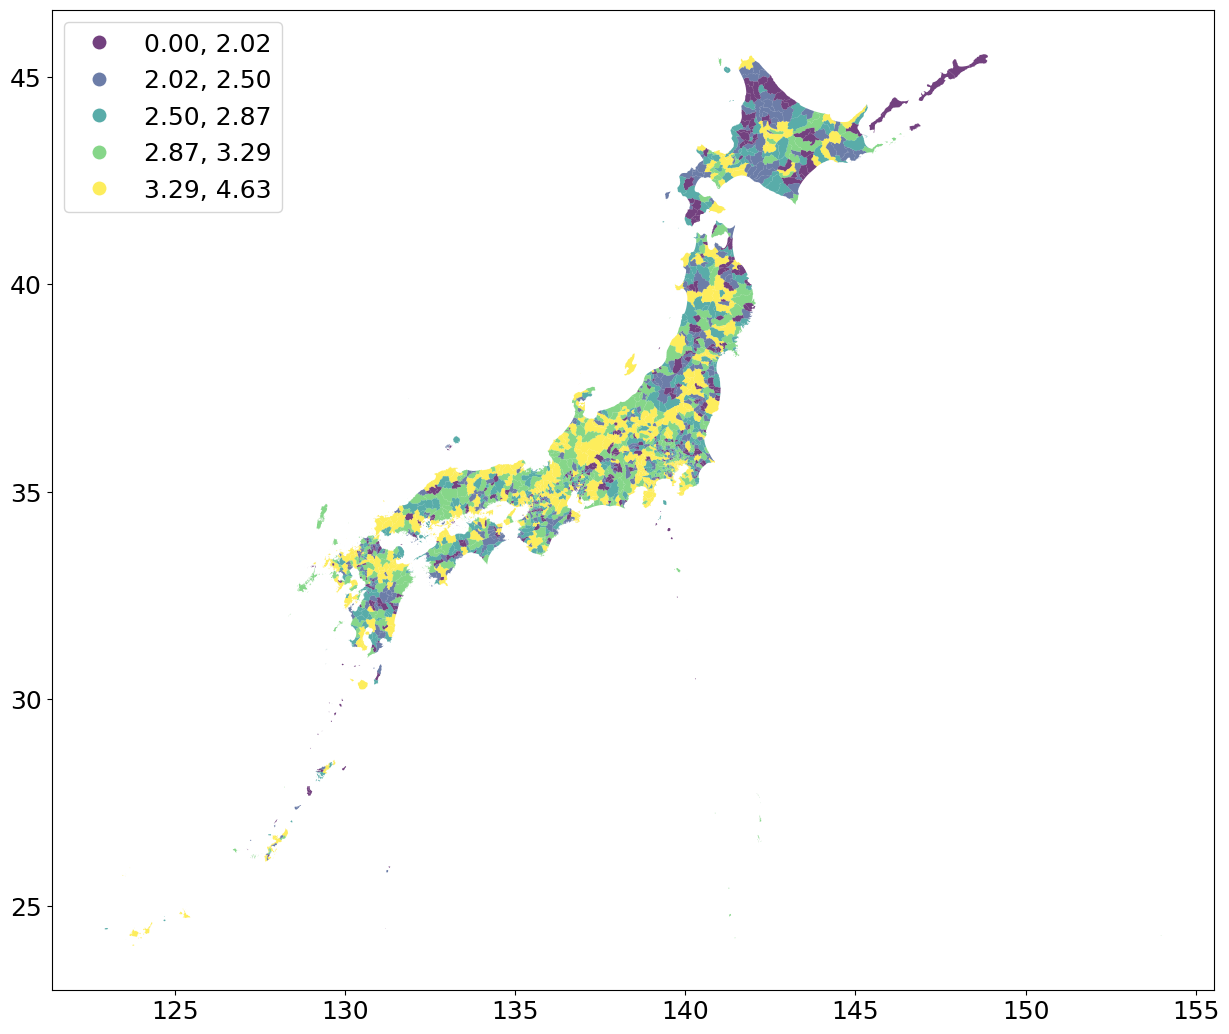

In [ ]:
gdf = gdf.to_crs(crs=DEFAULT_CRS)
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
gdf.plot(
    column='logreview_count',
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=axes_obj,
)

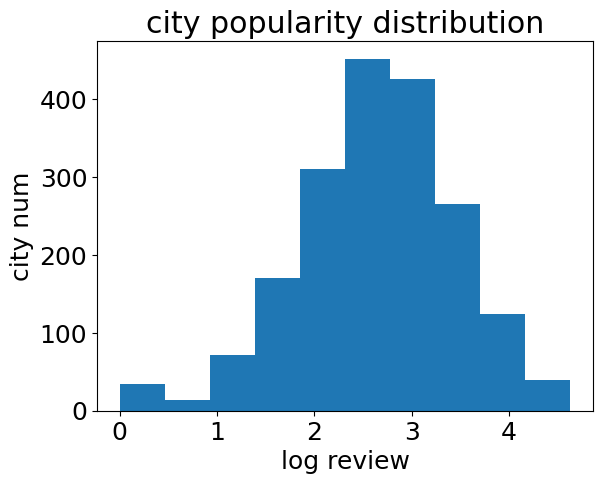

In [ ]:
plt.rcParams['font.size']=18
plt.title('city popularity distribution')
plt.xlabel('log review')
plt.ylabel('city num')
plt.hist(gdf['logreview_count'])
plt.savefig('city_pop_hist.png')

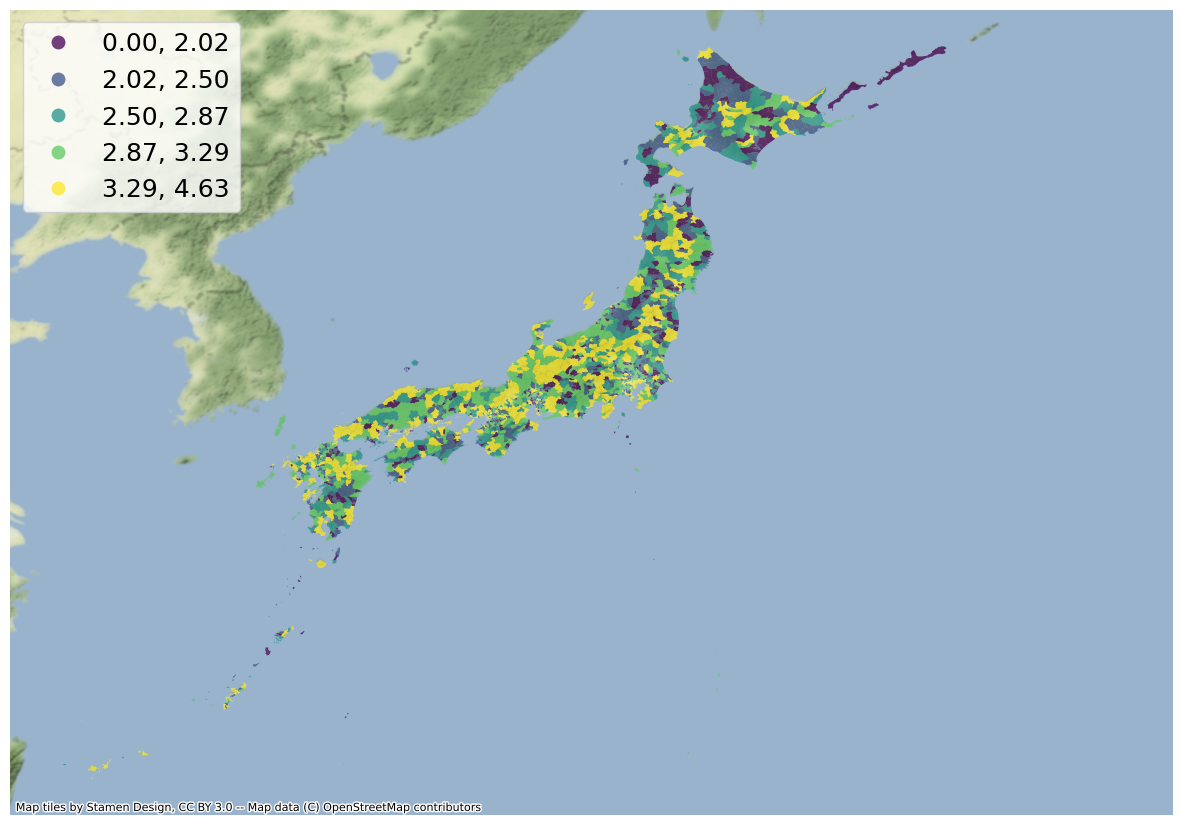

In [ ]:
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
axes_obj = create_choropleth_map(gdf=gdf, target_col="logreview_count", draw_axes=axes_obj)
plt.savefig('city_geodist.png')

In [ ]:
def compute_global_moran_i_statistic(
    gdf: gpd.GeoDataFrame, spatial_weight_matrix: weights.KNN, target_col: str, plot: bool
) -> esda.moran.Moran:
    moran_i_obj = esda.moran.Moran(y=gdf[target_col], w=spatial_weight_matrix)
    if plot:
        fig_obj, axes_obj = plot_moran(moran=moran_i_obj)
        fig_obj.savefig("japanmap_globalmoran.jpg")

    return moran_i_obj

def global_moran(gdf, target_col,k=8, plot=False):
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=k)
    spatial_weight_matrix.transform = "R"
    global_moran_obj = compute_global_moran_i_statistic(gdf, spatial_weight_matrix, target_col, plot=plot)
    print(f"[LOG] moran i statistic: {global_moran_obj.I}")
    print(f"[LOG] empirical p-value: {global_moran_obj.p_sim}")

[LOG] moran i statistic: 0.2089913305923336
[LOG] empirical p-value: 0.001


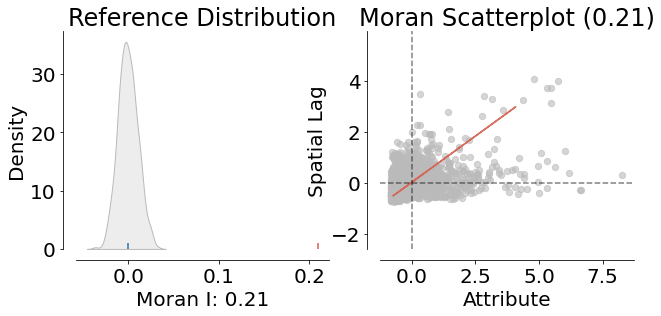

In [ ]:
global_moran(gdf, 'spot_num', plot=True)

In [ ]:
global_moran(gdf_exp, 'review_count', k=10)

[LOG] moran i statistic: 0.06458300772599881
[LOG] empirical p-value: 0.001


In [ ]:
global_moran(gdf, 'review_count'

NameError: name 'gdf' is not defined

In [ ]:
def compute_local_moran_i(gdf: gpd.GeoDataFrame, spatial_weight_matrix: weights.KNN, target_col: str, plot=False):

    local_moran_i_obj = esda.moran.Moran_Local(y=gdf[target_col], w=spatial_weight_matrix)

    return local_moran_i_obj


def local_moran(gdf, target_col, k=8, plot=False):
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=k)
    spatial_weight_matrix.transform = "R"
    local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col=target_col, plot=plot)
    print(f"[LOG] moran i statistic: {local_moran_obj.Is}")
    print(f"[LOG] empirical p-value: {local_moran_obj.p_sim}")

In [ ]:
local_moran(gdf, 'spot_num')

[LOG] moran i statistic: [-0.69134667  0.07320102  0.097398   ...  3.44448761  0.20293658
 -0.37794839]
[LOG] empirical p-value: [0.115 0.218 0.375 ... 0.005 0.001 0.088]


In [ ]:
local_moran(gdf_exp, 'review_count', k=10)

[LOG] moran i statistic: [ 7.33536371 -2.60093841  1.572268   ...  0.03842406  0.05856148
  0.04440553]
[LOG] empirical p-value: [0.078 0.268 0.122 ... 0.354 0.071 0.27 ]


In [ ]:
DEFAULT_CRS=4326
class ChoroplethMapLISA:
    def create_local_moran_i_choropleth_maps(self, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local):
        gdf = gdf.to_crs(crs=DEFAULT_CRS)

        fig_obj, axes_obj = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

        axes_obj = axes_obj.flatten()  # Make the axes accessible with single indexing

        axes_obj[0] = self._choropleth_local_statistic(axes_obj[0], gdf, local_moran_obj)
        axes_obj[1] = self._choropleth_quadrant_categories(axes_obj[1], gdf, local_moran_obj)
        axes_obj[2] = self._choropleth_significance_map(axes_obj[2], gdf, local_moran_obj)
        axes_obj[3] = self._choropleth_cluster_map(axes_obj[3], gdf, local_moran_obj)

        fig_obj.tight_layout()
        fig_obj.savefig("local_moran_i_choropleth_maps.jpg")

    def create_local_moran_i_choropleth_maps_p(self, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local):
        gdf = gdf.to_crs(crs=DEFAULT_CRS)

        fig_obj, axes_obj = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

        axes_obj = axes_obj.flatten()  # Make the axes accessible with single indexing

        axes_obj[0] = self._choropleth_cluster_map(axes_obj[0], gdf, local_moran_obj)

        fig_obj.tight_layout()
        fig_obj.savefig("local_moran_i_choropleth_maps.jpg")

    def _choropleth_local_statistic(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        df_temp = gdf.assign(Is=local_moran_obj.Is)
        axes_obj = df_temp.plot(
            column="Is",
            cmap="plasma",
            scheme="quantiles",
            k=5,
            edgecolor="white",
            linewidth=0.1,
            alpha=0.75,
            legend=True,
            ax=axes_obj,
        )
        axes_obj = self._arrange_axis_obj(axes_obj, "local_moran_i_statistic")
        return axes_obj

    def _choropleth_quadrant_categories(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        lisa_cluster(moran_loc=local_moran_obj, gdf=gdf, p=1, ax=axes_obj)  # 有意水準の設定(1に設定すると全てのObservationが有意として扱われる)
        axes_obj = self._arrange_axis_obj(axes_obj, "scatterplot_quadrant")
        return axes_obj

    def _choropleth_significance_map(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        # Recode 1 to "Significant and 0 to "Non-significant"
        significance_dammy_val_series = pd.Series(
            data=1 * (local_moran_obj.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
            index=gdf.index,  # Use the index in the original data
        )
        df_temp = gdf.assign(significance_dammy=significance_dammy_val_series)
        axes_obj = df_temp.plot(
            column="significance_dammy",
            categorical=True,
            k=2,
            cmap="Paired",
            linewidth=0.1,
            edgecolor="white",
            legend=True,
            ax=axes_obj,
        )

        axes_obj = self._arrange_axis_obj(axes_obj, "statistical_significance")

        return axes_obj

    def _choropleth_cluster_map(
        self, axes_obj: Axes, gdf: gpd.GeoDataFrame, local_moran_obj: esda.moran.Moran_Local
    ) -> Axes:
        lisa_cluster(moran_loc=local_moran_obj, gdf=gdf, p=0.05, ax=axes_obj)

        axes_obj = self._arrange_axis_obj(axes_obj, "moran_cluster_map")

        return axes_obj

    def _arrange_axis_obj(self, axes_obj: Axes, axes_title: str) -> Axes:
        axes_obj.set_axis_off()
        axes_obj.set_title(label=axes_title)

        contextily.add_basemap(
            ax=axes_obj,
            crs=DEFAULT_CRS,
            source=contextily.providers.Stamen.TerrainBackground,
        )
        return axes_obj

def LocalMoranMap(gdf, target_col, save=False):
    # 略
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=8)
    spatial_weight_matrix.transform = "R"
    local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col=target_col)
    choropleth_obj = ChoroplethMapLISA()
    fig_obj = choropleth_obj.create_local_moran_i_choropleth_maps(gdf, local_moran_obj)

def LocalMoranMap_p(gdf, target_col, save=False):
    # 略
    spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=8)
    spatial_weight_matrix.transform = "R"
    local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col=target_col)
    choropleth_obj = ChoroplethMapLISA()
    fig_obj = choropleth_obj.create_local_moran_i_choropleth_maps_p(gdf, local_moran_obj)

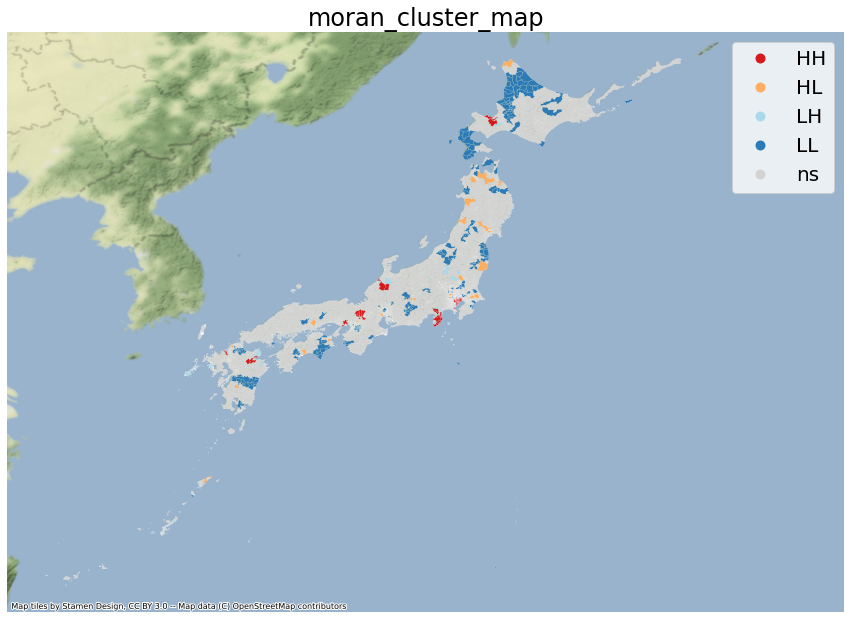

In [ ]:
plt.rcParams['font.size'] = 20
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf, k=8)
spatial_weight_matrix.transform = "R"
local_moran_obj = compute_local_moran_i(gdf=gdf, spatial_weight_matrix=spatial_weight_matrix, target_col='review_count')
choropleth_obj = ChoroplethMapLISA()
axes_obj = choropleth_obj._choropleth_cluster_map(axes_obj, gdf, local_moran_obj)
fig_obj.savefig("japanmap_localmoran.jpg")

In [ ]:
def isin(df):
    return shapely.geometry.Polygon([(122,20),(154,20),(154, 46), (122,46)]).contains(df['geometry'])
gdf_exp['isin'] = gdf_exp.progress_apply(isin, axis=1)

100%|██████████| 42852/42852 [00:05<00:00, 8395.02it/s] 


In [ ]:
gdf_exp = gdf_exp[gdf_exp['isin']==True]
len(gdf_exp)

42851

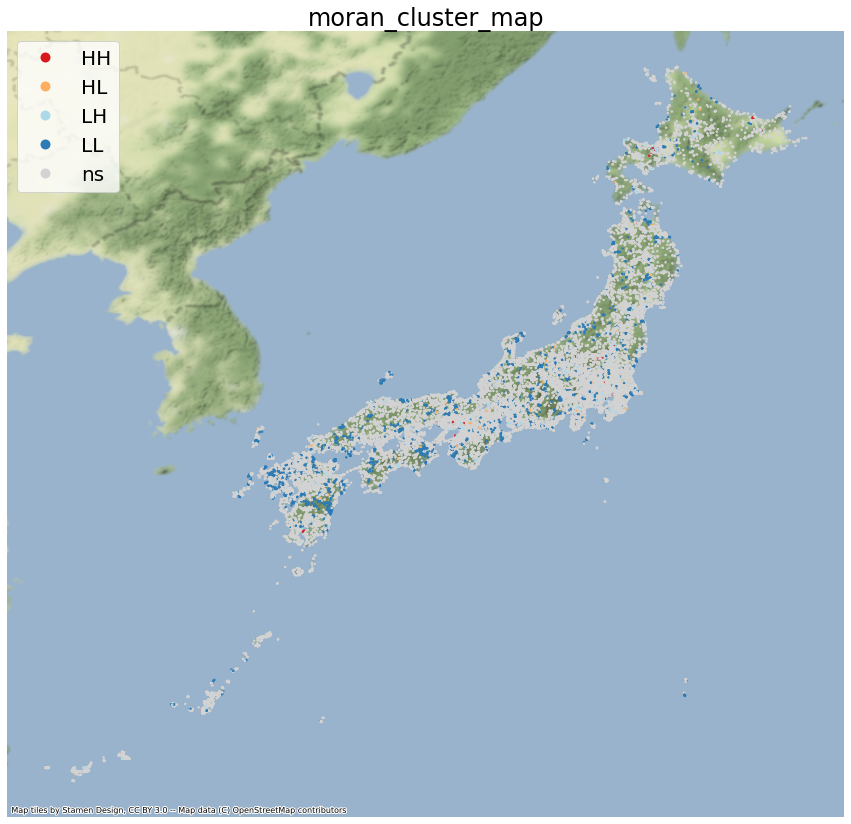

In [ ]:
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 1
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
spatial_weight_matrix = weights.KNN.from_dataframe(df=gdf_exp, k=8)
spatial_weight_matrix.transform = "R"
local_moran_obj = compute_local_moran_i(gdf=gdf_exp, spatial_weight_matrix=spatial_weight_matrix, target_col='review_count')
choropleth_obj = ChoroplethMapLISA()
axes_obj = choropleth_obj._choropleth_cluster_map(axes_obj, gdf_exp, local_moran_obj)
fig_obj.savefig("japanmap_localmoran_spot.jpg")

MLASK

In [ ]:
df_review = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/review/review_all_period_.csv')

In [ ]:
print(len(df_review))
df_review_ = df_review.drop_duplicates()
print(len(df_review_))

3558387
3558387


In [ ]:
from mlask import MLAsk
emotion_analyzer = MLAsk()

In [ ]:
import pandas as pd
import glob
import mlask
from tqdm import tqdm

emotion_lists = []
num=0
for text in tqdm(df_review['review']):
    num+=1
    emotion_list = []
    try:
        res = emotion_analyzer.analyze(text)
    #     print(res)
        try:
            t = res['emotion']['odoroki']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['kowa']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['yasu']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['yorokobi']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['iya']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['aware']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['haji']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['ikari']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['suki']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        try:
            t = res['emotion']['takaburi']
            emotion_list.append(t)
        except:
            emotion_list.append([])
        emotion_lists.append(emotion_list)
    except:
        emotion_lists.append([[],[],[],[],[],[],[],[],[],[]])
        print(text)


emotion_df = pd.DataFrame(emotion_lists, columns=['aware', 'haji', 'ikari', 'iya', 'kowa', 'odoroki', 'suki', 'takaburi', 'yasu', 'yorokobi'])
print(emotion_df)

100%|██████████| 3565959/3565959 [1:19:33<00:00, 746.99it/s] 


         aware haji             ikari                iya  kowa odoroki suki  \
0           []   []              [余裕]                 []    []      []   []   
1           []   []                []               [喜ぶ]    []      []   []   
2           []   []                []                 []    []      []   []   
3           []   []                []                 []    []      []   []   
4           []   []                []                 []    []      []   []   
...        ...  ...               ...                ...   ...     ...  ...   
3565954     []   []  [不安*CVS, 安心, 親切]               [丁寧]    []      []   []   
3565955     []   []              [安心]  [丁寧, 楽しい, 満足, 笑い]  [大変]      []   []   
3565956     []   []          [安心, 親切]                 []  [大変]      []   []   
3565957  [予想外]   []                []         [楽しい, 楽しむ]    []      []   []   
3565958     []   []              [親切]               [満足]    []      []   []   

        takaburi            yasu yorokobi  
0      

In [ ]:
emotion_df.to_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/emotion.csv')

In [ ]:
emotion_df = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity_final/data/emotion.csv')

形容詞

In [ ]:
import MeCab
tokenizer = MeCab.Tagger()
tokenizer.parse("")

def get_adjective(review):
    node = tokenizer.parseToNode(review)
    keywords = []
    while node:
        #if node.feature.split(",")[0] == u"名詞":
        #    keywords.append(node.surface)
        if node.feature.split(",")[0] == u"形容詞":
            keywords.append(node.feature.split(",")[6])
        #elif node.feature.split(",")[0] == u"動詞":
        #    keywords.append(node.feature.split(",")[6])
        node = node.next
    return keywords

def get_verb(review):
    node = tokenizer.parseToNode(review)
    keywords = []
    while node:
        #if node.feature.split(",")[0] == u"名詞":
        #    keywords.append(node.surface)
        if node.feature.split(",")[0] == u"動詞":
            keywords.append(node.feature.split(",")[6])
        #elif node.feature.split(",")[0] == u"動詞":
        #    keywords.append(node.feature.split(",")[6])
        node = node.next
    return keywords

def get_noun(review):
    node = tokenizer.parseToNode(review)
    keywords = []
    while node:
        #if node.feature.split(",")[0] == u"名詞":
        #    keywords.append(node.surface)
        if node.feature.split(",")[0] == u"名詞":
            keywords.append(node.feature.split(",")[6])
        #elif node.feature.split(",")[0] == u"動詞":
        #    keywords.append(node.feature.split(",")[6])
        node = node.next
    return keywords


In [ ]:
from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
df_review['noun'] = df_review['review'].parallel_apply(get_noun)
df_review['verb'] = df_review['review'].parallel_apply(get_verb)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
tqdm.pandas()
df_review['adjective'] = df_review['review'].parallel_apply(get_adjective)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
df_review['verb']

0          [持つ, 行く, 撮る, 持つ, いる, 入る, 撮る, できる, する, くださる, 思う...
1          [行く, 張り切る, 出かける, 乗る, する, なくなる, しまう, あきらめる, 戻る,...
2           [登る, 認める, いる, 恵まれる, 歩く, 登る, いる, いく, できる, 持つ, 望む]
3                                               [ある, 置く, 登る]
4                  [行ける, 狭める, なる, いる, 開ける, 照らす, れる, 伺う, 過ごす]
                                 ...                        
3565954    [する, する, いただく, 迎える, できる, する, れる, いる, 高まる, いただく...
3565955    [いる, 取れる, 誘う, れる, する, する, れる, 知る, 教える, もらう, する...
3565956    [できる, する, いただける, 向かう, 泳ぐ, できる, する, 楽しめる, する, い...
3565957    [なる, 楽しめる, する, 頂く, なる, 合わせる, 楽しむ, する, 頂く, する, ...
3565958                               [する, する, いただく, する, 行く]
Name: verb, Length: 3565959, dtype: object

GinZa

In [3]:
df_exp = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')
tfidf_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')
tfidf_topk_index = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_topk_index.npy')
tfidf_top_words = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/tfidf_top_words.npy')
df_exp['index'] = df_exp['Unnamed: 0']

In [4]:
valid_idx = np.load('/home/yamanishi/project/trip_recommend/data/jalan/graph/valid_idx.npy')
test_result = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/data/test_result.csv')
test_result['index'] = np.arange(42852)[valid_idx==1]
test_result['spot_name'] = test_result['spot_names']
test_result.head()
test_result = test_result.merge(df_exp, on='index')

In [5]:
df1 = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/data/test/test_result1.csv')
df2 = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/data/test/test_result4.csv')
df3 = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/data/test/test_result32.csv')
df4 = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/data/test/test_result59.csv')
df5 = pd.read_csv('/home/yamanishi/project/trip_recommend/model/popularity/data/test/test_result90.csv')
pred = (df1['pred'].values + df2['pred'].values + df3['pred'].values + df4['pred'].values + df5['pred'].values)/5
test_result['pred'] = pred

In [8]:
import geopandas as gpd
pref_gdf=gpd.read_file('/home/yamanishi/project/trip_recommend/model/popularity_final/data/prefectures.geojson')

In [10]:
pref_cor = [0]*47
for i,pref in enumerate(pref_gdf['name']):
    test_result_tmp = test_result[test_result['prefecture']==pref]
    cor = np.corrcoef(test_result_tmp['pred'], test_result_tmp['gt'])
    pref_cor[i] = cor[0][1]
    count = len(test_result_tmp['pred'])
    for spot_name, gt, pred in test_result_tmp[['spot_names', 'gt', 'pred']].values:
        print(spot_name, gt, pred, pref, round(cor[0][1], 3), count)
    #print(test_result_tmp[['spot_names', 'gt', 'pred']].values, pref, cor)

pref_gdf['cor'] = np.array(pref_cor)

旭山動物園 3.6490426 2.41336012 北海道 0.831 230
四季彩の丘 3.0762763 2.47061262 北海道 0.831 230
旭岳 2.7678976 2.3282369 北海道 0.831 230
五稜郭公園 3.1212316 2.3703497 北海道 0.831 230
ファーム富田 3.3811152 2.60033996 北海道 0.831 230
オシンコシンの滝 3.134496 2.5509285200000003 北海道 0.831 230
ふきだし公園 2.8668778 2.1138945000000002 北海道 0.831 230
大倉山ジャンプ競技場 3.07225 2.4066216799999998 北海道 0.831 230
和商市場 2.9552066 2.48380444 北海道 0.831 230
羊蹄山（北海道京極町） 2.7604225 2.16246552 北海道 0.831 230
清水公園（北海道清水町） 2.5010593 2.1347278 北海道 0.831 230
層雲峡（北海道上川町） 2.9289076 2.40735594 北海道 0.831 230
中島公園（北海道帯広市） 2.376577 1.89074708 北海道 0.831 230
富良野チーズ工房 2.8142476 2.00873074 北海道 0.831 230
フラノ・マルシェ　フラノ・マルシェ２ 2.7909884 2.3422339 北海道 0.831 230
札幌市青少年科学館 2.774517 2.22712052 北海道 0.831 230
トラピスチヌ修道院 2.79588 2.13727732 北海道 0.831 230
稚内港北防波堤ドーム 2.5831988 2.14065626 北海道 0.831 230
ひかりの屋台大門横丁 2.340444 2.95663886 北海道 0.831 230
おびひろ動物園 2.666518 2.90768202 北海道 0.831 230
然別湖 2.5622928 1.7137852800000002 北海道 0.831 230
桂沢湖（体験観光） 2.0334237 1.8988029999999998 北海道 0.831 230
屈

In [17]:
test_result['over'] = test_result['pred']-test_result['gt']
test_result.sort_values('over', ascending=False).head(10)

Unnamed: 0_x               spot_names        gt      pred  index  \
4006          4006           旧石巻ハリストス正教会教会堂  0.845098  2.188364  40210   
3630          3630                  真玉海岸の夕陽  0.845098  1.979093  36709   
2112          2112                  篠島，日間賀島  1.633468  2.728250  21349   
1337          1337               プラン・ド・ヴェール  1.000000  2.038180  13811   
2220          2220                     福王神社  1.041393  2.071380  22512   
99              99  北海道立真駒内公園屋内競技場（アイスアリーナ）  1.477121  2.506371   1051   
1650          1650                 新潟市新津美術館  1.176091  2.195827  16926   
3910          3910                     美崎御嶽  1.397940  2.390114  39239   
56              56                   パレットの丘  1.041393  2.030839    535   
3685          3685                     夢見が丘  1.301030  2.279720  37260   

                  spot_name_x  Unnamed: 0_y              spot_name_y  \
4006           旧石巻ハリストス正教会教会堂         40210           旧石巻ハリストス正教会教会堂   
3630                  真玉海岸の夕陽         36709                  真玉海岸の夕陽   
2112                  篠島，日間賀島         21349                  篠島，日間賀島   
1337               プラン・ド・ヴェール         13811               プラン・ド・ヴェール   
2220                     福王神社         22512                     福王神社   
99    北海道立真駒内公園屋内競技場（アイスアリーナ）          1051  北海道立真駒内公園屋内競技場（アイスアリーナ）   
1650                 新潟市新津美術館         16926                 新潟市新津美術館   
3910                     美崎御嶽         39239                     美崎御嶽   
56                     パレットの丘           535                   パレットの丘   
3685                     夢見が丘         37260                     夢見が丘   

     prefecture                                                url  ...  \
4006        宮城県  https://www.jalan.net/kankou/spt_04202ae218002...  ...   
3630        大分県  https://www.jalan.net/kankou/spt_44209aj220206...  ...   
2112        愛知県  https://www.jalan.net/kankou/spt_23445ab205000...  ...   
1337       神奈川県  https://www.jalan.net/kankou/spt_guide00000015...  ...   
2220        三重県  https://www.jalan.net/kankou/spt_24341ag213001...  ...   
99          北海道  https://www.jalan.net/kankou/spt_01106ca348005...  ...   
1650        新潟県  https://www.jalan.net/kankou/spt_15105ae330208...  ...   
3910        沖縄県  https://www.jalan.net/kankou/spt_47207af217002...  ...   
56          北海道  https://www.jalan.net/kankou/spt_01224aj220201...  ...   
3685        宮崎県  https://www.jalan.net/kankou/spt_45202ga355015...  ...   

     review_count   latitude   longitude              area       city   town  \
4006          7.0  38.429183  141.311113            石巻・気仙沼        石巻市     中瀬   
3630          7.0  33.622665  131.473020             中津・国東      豊後高田市     臼野   
2112         43.0  34.704502  137.004470                知多  南知多町（知多郡）   日間賀島   
1337         10.0  35.249340  139.046672                箱根  箱根町（足柄下郡）     強羅   
2220         11.0  35.084389  136.476817  桑名・長島・四日市・湯の山・鈴鹿   菰野町（三重郡）     田口   
99           30.0  42.999395  141.347333                札幌      札幌市南区  真駒内公園   
1650         15.0  37.762622  139.112250        新潟・月岡・阿賀野川     新潟市秋葉区     金津   
3910         25.0  24.335485  124.158510                離島        石垣市    登野城   
56           11.0  42.916435  141.751256          石狩・空知・千歳        千歳市     幌加   
3685         20.0  31.844941  130.882277            えびの・都城        都城市   吉之元町   

     review_count_rank valid city_processed      over  
4006           10798.0     6            石巻市  1.343266  
3630           10557.0     8          豊後高田市  1.133995  
2112           31965.0     6           南知多町  1.094781  
1337           15556.0     9            箱根町  1.038180  
2220           17365.0     8            菰野町  1.029987  
99             29006.0     7            札幌市  1.029249  
1650           21756.0     4            新潟市  1.019736  
3910           27693.0     1            石垣市  0.992174  
56             16640.0     4            千歳市  0.989446  
3685           25586.0     5            都城市  0.978690  

[10 rows x 23 columns]

In [19]:
test_result['under'] = test_result['gt']-test_result['pred']
test_result.sort_values('under', ascending=False).head(10)

Unnamed: 0_x       spot_names        gt      pred  index  \
2088          2088    えびせんべいの里　美浜本店  3.386321  1.390622  21066   
1984          1984             高山陣屋  2.910624  1.224891  20152   
1693          1693  aisorashi-アイソラシ  3.562650  1.926744  17342   
1426          1426          大王わさび農場  3.172895  1.606333  14769   
2194          2194            おかげ横丁  3.665769  2.210485  22224   
3391          3391    九十九島パールシーリゾート  3.025306  1.675642  34447   
990            990              六義園  2.954242  1.659145  10078   
1821          1821              熱海城  3.041393  1.788591  18589   
0                0            旭山動物園  3.649043  2.413360      1   
3771          3771           鴨池運動公園  2.382017  1.174550  38121   

          spot_name_x  Unnamed: 0_y      spot_name_y prefecture  \
2088    えびせんべいの里　美浜本店         21066    えびせんべいの里　美浜本店        愛知県   
1984             高山陣屋         20152             高山陣屋        岐阜県   
1693  aisorashi-アイソラシ         17342  aisorashi-アイソラシ        石川県   
1426          大王わさび農場         14769          大王わさび農場        長野県   
2194            おかげ横丁         22224            おかげ横丁        三重県   
3391    九十九島パールシーリゾート         34447    九十九島パールシーリゾート        長崎県   
990               六義園         10078              六義園        東京都   
1821              熱海城         18589              熱海城        静岡県   
0               旭山動物園             1            旭山動物園        北海道   
3771           鴨池運動公園         38121           鴨池運動公園       鹿児島県   

                                                    url  ...   latitude  \
2088  https://www.jalan.net/kankou/spt_guide00000021...  ...  34.793753   
1984  https://www.jalan.net/kankou/spt_21203ae218002...  ...  36.139669   
1693  https://www.jalan.net/kankou/spt_guide00000020...  ...  36.572978   
1426  https://www.jalan.net/kankou/spt_20462cb351016...  ...  36.338908   
2194  https://www.jalan.net/kankou/spt_24203aj220002...  ...  34.462906   
3391  https://www.jalan.net/kankou/spt_42202cc336004...  ...  33.161256   
990   https://www.jalan.net/kankou/spt_13105ah214001...  ...  35.733650   
1821  https://www.jalan.net/kankou/spt_22205af212000...  ...  35.086381   
0     https://www.jalan.net/kankou/spt_01204cc331004...  ...  43.768939   
3771  https://www.jalan.net/kankou/spt_46201ah333004...  ...  31.564923   

       longitude            area      city    town  review_count_rank valid  \
2088  136.893897              知多  美浜町（知多郡）  北方（大字）            42736.0     1   
1984  137.257674           飛騨・高山       高山市     八軒町            42139.0     7   
1693  136.665628           金沢・羽咋       金沢市      東山            42812.0     4   
1426  137.909006          安曇野・大町      安曇野市      穂高            42564.0     1   
2194  136.722764           伊勢・二見       伊勢市  宇治中之切町            42834.0     3   
3391  129.678967     佐世保・ハウステンボス      佐世保市    鹿子前町            42355.0     3   
990   139.745960  お茶の水・湯島・九段・後楽園       文京区     本駒込            42235.0     0   
1821  139.078678              熱海       熱海市      熱海            42386.0     1   
0     142.479652          旭川・層雲峡       旭川市  東旭川町倉沼            42830.0     6   
3771  130.558973          鹿児島・桜島      鹿児島市     与次郎            39879.0     9   

     city_processed      over     under  
2088            美浜町 -1.995698  1.995698  
1984            高山市 -1.685734  1.685734  
1693            金沢市 -1.635906  1.635906  
1426           安曇野市 -1.566562  1.566562  
2194            伊勢市 -1.455283  1.455283  
3391           佐世保市 -1.349664  1.349664  
990             文京区 -1.295097  1.295097  
1821            熱海市 -1.252802  1.252802  
0               旭川市 -1.235682  1.235682  
3771           鹿児島市 -1.207467  1.207467  

[10 rows x 24 columns]

In [53]:
pref_cor = [0]*47
for i,pref in enumerate(pref_gdf['name']):
    over, under=0, 0
    test_result_tmp = test_result[test_result['prefecture']==pref]
    for gt, pred in zip(test_result_tmp['gt'], test_result_tmp['pred']):
        if pred>gt:
            over+=1
        else:
            under+=1
    cor = np.corrcoef(test_result_tmp['pred'], test_result_tmp['gt'])[0][1]
    print(pref, over, under, cor)
    #print(pref, np.mean(test_result_tmp['gt']), np.std(test_result_tmp['gt']))
    #print(np.std(test_result_tmp['gt']))
    #cor = np.corrcoef(test_result_tmp['pred'], test_result_tmp['gt'])
    #pref_cor[i] = cor[0][1]

#pref_gdf['cor'] = np.array(pref_cor)

北海道 123 107 0.8312495375188494
青森県 27 37 0.8506253924442956
岩手県 27 24 0.8442837791259882
宮城県 33 34 0.8230531280145065
秋田県 25 26 0.8152390970737989
山形県 30 25 0.7829299782490706
福島県 56 30 0.8597545062431806
茨城県 40 22 0.8689407177268039
栃木県 43 44 0.8039895377447064
群馬県 60 38 0.7905017971852901
埼玉県 53 42 0.8280100640250507
千葉県 65 46 0.8417082988220488
東京都 130 132 0.8435846934951863
神奈川県 78 77 0.8627262922157685
新潟県 53 30 0.816251529565684
富山県 28 15 0.8783278478142693
石川県 48 28 0.7550215699972672
福井県 21 38 0.8043723521224655
山梨県 41 22 0.8689953209763722
長野県 95 65 0.7944577495255908
岐阜県 75 42 0.7834271961647743
静岡県 112 74 0.8671498027416048
愛知県 72 38 0.7211275122685948
三重県 41 38 0.8461236991273505
滋賀県 36 31 0.8358343316137388
京都府 76 45 0.8347105260266395
大阪府 75 50 0.8236770058003775
兵庫県 67 52 0.8409640167042618
奈良県 35 21 0.8738910803379125
和歌山県 48 42 0.8850545724952301
鳥取県 20 8 0.8900097568673352
島根県 26 21 0.836513968630285
岡山県 33 29 0.7789083142569799
広島県 45 30 0.8264114235455793
山口県 38 30 

In [15]:
pref_cor = [0]*47
for i,pref in enumerate(pref_gdf['name']):
    test_result_tmp = test_result[test_result['prefecture']==pref]
    print(pref, np.mean(test_result_tmp['pred']), np.std(test_result_tmp['pred']))
    print(np.std(test_result_tmp['gt']))
    cor = np.corrcoef(test_result_tmp['pred'], test_result_tmp['gt'])
    pref_cor[i] = cor[0][1]

#pref_gdf['cor'] = np.array(pref_cor)

北海道 1.4228970459565216 0.541787911856467
青森県 1.252833375625 0.5528626295025545
岩手県 1.3382129927450979 0.4708243145596883
宮城県 1.3604585156716418 0.5652671767227216
秋田県 1.2571008015686278 0.4408752218805263
山形県 1.2228462867272727 0.47679092830337094
福島県 1.3991708022093021 0.5361437215037927
茨城県 1.2762431635483868 0.5102550611564123
栃木県 1.3565806452873563 0.51100818347484
群馬県 1.301140177142857 0.47703030993220596
埼玉県 1.2871132033684207 0.45257585403120065
千葉県 1.328190958018018 0.5664743552688943
東京都 1.3339936603053435 0.5218490512555403
神奈川県 1.2983063845806453 0.49264747690501887
新潟県 1.2141682627710844 0.5142510478231626
富山県 1.3143234883720931 0.4950232726973547
石川県 1.1416218405263159 0.40987179105736266
福井県 1.1767182101694917 0.37701361046071974
山梨県 1.3255127393650794 0.48841698374467485
長野県 1.277483077 0.45485707176504203
岐阜県 1.2413493482051283 0.4451415449867942
静岡県 1.33691182327957 0.532367660488729
愛知県 1.3040654778181815 0.4836998480093877
三重県 1.2788681956962027 0.5242001131286476
滋賀

In [13]:
np.corrcoef(test_result['gt'], test_result['pred'])

array([[1.       , 0.8323871],
       [0.8323871, 1.       ]])

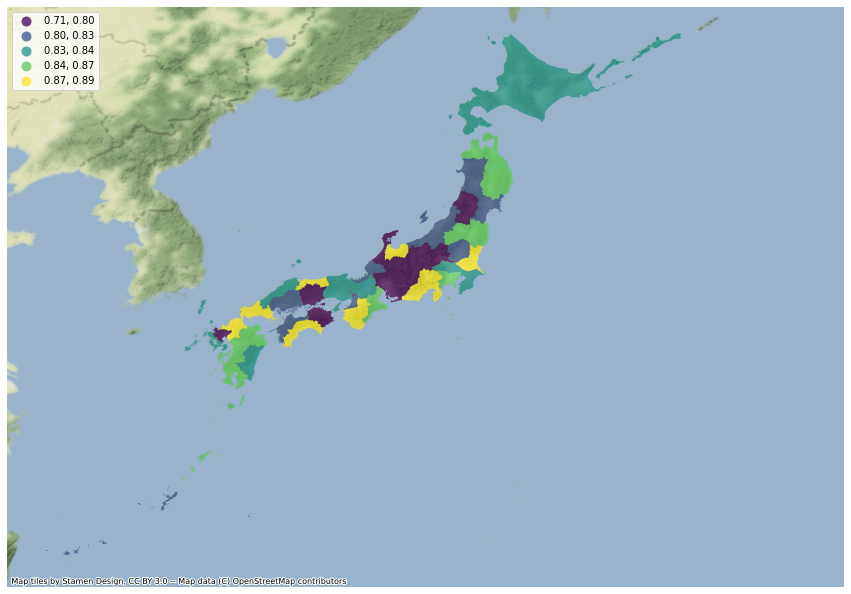

In [11]:
fig_obj, axes_obj = plt.subplots(1, figsize=(15, 15))
axes_obj = create_choropleth_map(gdf=pref_gdf, target_col="cor", draw_axes=axes_obj)
fig_obj.savefig('japan_cor.png')

In [12]:
for name, cor in zip(pref_gdf['name'], pref_gdf['cor']):
    print(name, cor)

北海道 0.8312495375188494
青森県 0.8506253924442956
岩手県 0.8442837791259882
宮城県 0.8230531280145065
秋田県 0.8152390970737989
山形県 0.7829299782490706
福島県 0.8597545062431806
茨城県 0.8689407177268039
栃木県 0.8039895377447064
群馬県 0.7905017971852901
埼玉県 0.8280100640250507
千葉県 0.8417082988220488
東京都 0.8435846934951863
神奈川県 0.8627262922157685
新潟県 0.816251529565684
富山県 0.8783278478142693
石川県 0.7550215699972672
福井県 0.8043723521224655
山梨県 0.8689953209763722
長野県 0.7944577495255908
岐阜県 0.7834271961647743
静岡県 0.8671498027416048
愛知県 0.7211275122685948
三重県 0.8461236991273505
滋賀県 0.8358343316137388
京都府 0.8347105260266395
大阪府 0.8236770058003775
兵庫県 0.8409640167042618
奈良県 0.8738910803379125
和歌山県 0.8850545724952301
鳥取県 0.8900097568673352
島根県 0.836513968630285
岡山県 0.7789083142569799
広島県 0.8264114235455793
山口県 0.8767211368277027
徳島県 0.7851089077768313
香川県 0.7080946179088957
愛媛県 0.8198978619787948
高知県 0.8798827277147084
福岡県 0.8946424265897746
佐賀県 0.7590302570002595
長崎県 0.8408952027151883
熊本県 0.842758146373401
大分県 0.847277

In [12]:
for name, pref, gt, pred in zip(pref_gdf['name'], pref_gdf['pref'], pref_gdf['gt'], pref_gdf['pred']):
    if abs(gt-pred)>1:
        print(name, pref, gt, pred)

KeyError: 'gt'

In [13]:
with open('/home/yamanishi/project/trip_recommend/data/jalan/graph/category_index.pkl', 'rb') as f:
    category_index = pickle.load(f)
category = category_index.keys()
category = list(category)

In [24]:
def jenre_cor(text):
    contain = [False]*len(test_result)
    for i,j in enumerate(test_result['jenre'].values):
        j = j.split(',')
        if text in j:
            contain[i] = True
        #print(text, j, contain)
    #print(contain)
    pred = test_result['pred'][contain]
    gt = test_result['gt'][contain]
    cor = np.corrcoef(pred, gt)
    return cor, contain.count(True)
jenre_cor(category[2])

(array([[1.        , 0.84775805],
        [0.84775805, 1.        ]]),
 1351)

In [35]:
pref_gdf.columns

Index(['pref', 'name', 'geometry', 'cor'], dtype='object')

In [39]:
pref_to_cor = {p:c for p,c in zip(pref_gdf['name'], pref_gdf['cor'])}

In [47]:
from collections import defaultdict
d_under = defaultdict(int)
d_over = defaultdict(int)
for pref in test_result['prefecture'].unique():
    test_result_tmp = test_result[test_result['prefecture']==pref]
    for jenre in test_result_tmp['jenre']:
        jenre = jenre.split(',')
        for j in jenre:
            if pref_to_cor[pref]<0.8:
                d_under[j]+=1
            else:
                d_over[j]+=1
sm=sum(d_under.values())
d_under = {k: v/sm for k,v in d_under.items()}
d_under = {k: round(v, 3) for k,v in d_under.items()}
sm=sum(d_over.values())
d_over = {k: v/sm for k,v in d_over.items()}
d_over = {k: round(v, 3) for k,v in d_over.items()}

In [49]:
print(d_over)
print('¥n')
print(d_under)

{'観光施設・名所巡り': 0.142, '動物園・植物園': 0.028, 'エンタメ・アミューズメント': 0.005, 'テーマパーク・レジャーランド': 0.002, '自然景観・絶景': 0.048, '山岳': 0.009, '公園・庭園': 0.03, '海岸景観': 0.01, '展望台・展望施設': 0.009, 'ショッピング': 0.015, 'その他ショッピング': 0.011, '運河・河川景観': 0.008, '産業観光施設': 0.004, 'ミュージアム・ギャラリー': 0.032, '博物館': 0.018, '神社・神宮・寺院': 0.051, 'その他神社・神宮・寺院': 0.048, '歴史的建造物': 0.013, '湖沼': 0.004, 'レジャー・体験': 0.038, '漁業体験・潮干狩り・地引網': 0.003, '風呂・スパ・サロン': 0.033, '健康ランド・スーパー銭湯': 0.013, '自然歩道・自然研究路': 0.002, '特産物（味覚）': 0.002, '日帰り温泉': 0.012, '自然現象': 0.002, 'その他': 0.023, 'その他名所': 0.019, 'その他スポーツ・フィットネス': 0.02, '乗馬': 0.001, '雪・スノースポーツ': 0.003, 'スキー・スノーボード': 0.002, 'バイキング・ビュッフェ・ホテルレストラン': 0.009, 'その他レジャー・体験': 0.009, '洋菓子・パン作り': 0.001, '道の駅・サービスエリア': 0.01, 'アウトドア': 0.014, 'パラグライダー': 0.0, 'スポーツリゾート施設': 0.004, '観光案内所': 0.008, '美術館': 0.007, 'その他自然景観・絶景': 0.001, 'その他観光施設': 0.002, '乗り物': 0.018, 'ケーブルカー・ロープウェイ': 0.002, 'ウォータースポーツ・マリンスポーツ': 0.024, 'カヌー・カヤック': 0.004, '川下り・ライン下り': 0.0, '特殊地形': 0.004, '町めぐり・食べ歩き': 0.001, 'トレッキング・登山': 0.001, '文化史跡・遺跡': 0.02, '

In [51]:
d_dif = {}
for k in d_over.keys():
    if k in d_under:
        d_dif[k] = d_over[k]-d_under[k]
        
d_dif

{'観光施設・名所巡り': -0.0030000000000000027,
 '動物園・植物園': -0.007000000000000003,
 'エンタメ・アミューズメント': 0.002,
 'テーマパーク・レジャーランド': 0.0,
 '自然景観・絶景': 0.005999999999999998,
 '山岳': -0.003000000000000001,
 '公園・庭園': 0.005999999999999998,
 '海岸景観': 0.006,
 '展望台・展望施設': 0.003999999999999999,
 'ショッピング': 0.002999999999999999,
 'その他ショッピング': 0.003999999999999999,
 '運河・河川景観': -0.002999999999999999,
 '産業観光施設': -0.001,
 'ミュージアム・ギャラリー': -0.0030000000000000027,
 '博物館': -0.004,
 '神社・神宮・寺院': 0.008,
 'その他神社・神宮・寺院': 0.005999999999999998,
 '歴史的建造物': -0.003000000000000001,
 '湖沼': 0.001,
 'レジャー・体験': -0.0030000000000000027,
 '漁業体験・潮干狩り・地引網': -0.001,
 '風呂・スパ・サロン': -0.026999999999999996,
 '健康ランド・スーパー銭湯': -0.004999999999999999,
 '自然歩道・自然研究路': 0.0,
 '特産物（味覚）': 0.001,
 '日帰り温泉': -0.004,
 'その他': 0.004,
 'その他名所': 0.0019999999999999983,
 'その他スポーツ・フィットネス': 0.004,
 '雪・スノースポーツ': -0.012,
 'スキー・スノーボード': -0.009,
 'バイキング・ビュッフェ・ホテルレストラン': 0.003999999999999999,
 'その他レジャー・体験': 0.002999999999999999,
 '洋菓子・パン作り': -0.001,
 '道の駅・サービスエリア': -0.004,
 

In [27]:
for i in range(len(category)):
     cor, cont = jenre_cor(category[i])
     print(category[i],cor[0][1], cont)

自然景観・絶景 0.8517091870229512 446
山岳 0.8589557377050836 93
観光施設・名所巡り 0.8477580485427645 1351
動物園・植物園 0.8765588384494862 279
ショッピング 0.8269869813711728 141
その他ショッピング 0.8138698696875875 97
海岸景観 0.843134290772985 82
果物・野菜狩り 0.7977783947627524 113
さくらんぼ狩り 0.9440522656744031 9
梨狩り 0.6362903757670876 4
桃狩り 0.663945954591165 6
ぶどう狩り 0.6923885561489186 12
その他果物・野菜狩り 0.9478736563245618 13
乗り物 0.838212851451214 154
クルーズ・クルージング 0.7547080010347104 23
湖沼 0.8528290787318678 39
神社・神宮・寺院 0.8254101037705552 471
その他神社・神宮・寺院 0.830102143099656 445
公園・庭園 0.8291758157312498 276
エンタメ・アミューズメント 0.7936497897288872 48
テーマパーク・レジャーランド 0.832378697106301 20
その他 0.8234588325701847 209
その他名所 0.8409295125429479 178
ミュージアム・ギャラリー 0.8109085526714267 315
博物館 0.8306033933295667 182
産業観光施設 0.8448205699886309 41
展望台・展望施設 0.8890541662841096 78
運河・河川景観 0.8836103757093599 81
歴史的建造物 0.7356811999434266 133
町並み 0.8440431577884691 31
町めぐり・食べ歩き 0.971172892761271 10
風呂・スパ・サロン 0.813817424399059 345
日帰り温泉 0.7900425044766911 123
高原 0.7598578

In [ ]:
df = pd.read_csv('/home/yamanishi/project/trip_recommend/data/jalan/spot/experience_light.csv')

In [4]:
import Levenshtein

string1 = "井上泰治"
string2 = "井上泰次"


print(Levenshtein.ratio(string1, string2))

0.75


In [7]:
from tqdm import tqdm
spot_names = df_exp['spot_name'].values
ratios = np.zeros((len(spot_names), len(spot_names)))
for i,s in tqdm(enumerate(spot_names)):
    for j in range(i, len(spot_names)):
        t = spot_names[j]
        ratio = Levenshtein.ratio(s,t)  
        ratios[i, j]=ratio
        ratios[j, i]=ratio

42852it [16:28, 43.37it/s]  


In [11]:
len(np.where(ratios>0.5)[0])

1382618

In [44]:
name_sim=np.where(ratios>0.7)

In [48]:
name_sim=np.array([name_sim[0], name_sim[1]])

In [49]:
name_sim

array([[    0,     0,     1, ..., 42850, 42851, 42851],
       [    0,    22,     1, ..., 42850, 37894, 42851]])

In [50]:
name_sim = name_sim[:, list(name_sim[0]!=name_sim[1])]

In [53]:
count=0
for s, t in zip(name_sim[0], name_sim[1]):
    print(spot_names[s], spot_names[t])
    count+=1
    #if count==1000:
    #    break

函館山 函館
旭山動物園 円山動物園
旭山動物園 茶臼山動物園
旭山動物園 西山動物園
旭山動物園 東山動植物園
旭山動物園 大内山動物園
旭山動物園 野毛山動物園
小樽青の洞窟クルーズ 小樽青の洞窟　龍宮クルーズ
小樽青の洞窟クルーズ 小樽　青の洞窟　釣り体験付きクルーズ
円山動物園 旭山動物園
円山動物園 茶臼山動物園
円山動物園 西山動物園
円山動物園 東山動植物園
円山動物園 大内山動物園
円山動物園 野毛山動物園
藻岩山（北海道札幌市） 円山公園（北海道札幌市）
青い池 白金青い池
青い池 青池
大通公園 大洋公園
大通公園 大滝公園
大通公園 大槻公園
大通公園 大室公園
大通公園 大宮公園
大通公園 大師公園
大通公園 大通り公園
大通公園 大石公園
大通公園 大西公園
大通公園 大垣公園
大通公園 久屋大通公園
大通公園 大倉公園
大通公園 大石公園
大通公園 大浜公園
大通公園 大中公園
大通公園 大元公園
大通公園 大濠公園
大通公園 大村公園
大通公園 大通峠公園
大通公園 大友公園
大通公園 大貞公園
大通公園 於大公園
大通公園 大仙公園
四季彩の丘 四季の丘公園
函館山展望台 恵山展望台
函館山展望台 岩山展望台
函館山展望台 亀山展望台
函館山展望台 桜山展望台
函館山展望台 石山展望台
函館山展望台 横山展望台
函館山展望台 金山展望台
函館山展望台 大山展望台
函館山展望台 弥山展望台
函館山展望台 椿山展望台
函館山展望台 城山展望台
函館山展望台 米山展望台
函館山展望台 鋸山展望台
函館山展望台 牧山展望台
函館山展望台 東館山展望台
函館 函館山
函館ハリストス正教会 豊橋ハリストス正教会
函館ハリストス正教会 金成ハリストス正教会
支笏湖 支笏湖温泉
硫黄山（北海道弟子屈町） 硫黄山（北海道斜里町）
硫黄山（北海道弟子屈町） 川湯温泉（北海道弟子屈町）
硫黄山（北海道弟子屈町） 藻琴山（北海道弟子屈町）
登別温泉 幕別温泉
登別温泉 別所温泉
登別温泉 別府温泉
五稜郭公園 五稜郭公園の桜
ファーム富田 ファームズ千代田
宗谷岬 宗谷岬公園
札幌大倉山展望台 大観山展望台
札幌大倉山展望台 大黒山展望台
札幌大倉山展望台 大峰山展望台
札幌大倉山展望台 大山展望台
札幌大倉山展望台 大星山展望台
札幌大倉山展望台 大堂山展

In [58]:
from torch.nn import LSTM
lstm = LSTM(40, 40, batch_first=True)

In [3]:

from typing import Optional

from torch import Tensor
from torch.nn import LSTM

from torch_geometric.nn.aggr import Aggregation


class LSTMAggregation(Aggregation):
    r"""Performs LSTM-style aggregation in which the elements to aggregate are
    interpreted as a sequence, as described in the `"Inductive Representation
    Learning on Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper.

    .. warning::
        :class:`LSTMAggregation` is not a permutation-invariant operator.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        **kwargs (optional): Additional arguments of :class:`torch.nn.LSTM`.
    """
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lstm = LSTM(in_channels, out_channels, batch_first=True, **kwargs)
        self.reset_parameters()

    def reset_parameters(self):
        self.lstm.reset_parameters()


    def forward(self, x: Tensor, index: Optional[Tensor] = None,
                ptr: Optional[Tensor] = None, dim_size: Optional[int] = None,
                dim: int = -2) -> Tensor:
        x, _ = self.to_dense_batch(x, index, ptr, dim_size, dim)
        return self.lstm(x)[0][:, -1]


    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels})')

In [6]:
torch.tensor([[1,2,3], [3,6,7]]).size()

torch.Size([2, 3])

In [4]:
aggr = LSTMAggregation(40, 40)
aggr(torch.rand(50, 40), torch.tensor([[1,2,3], [3,6,7]]))

RuntimeError: expand(torch.LongTensor{[2, 3]}, size=[50]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [56]:
np.save('/home/yamanishi/project/trip_recommend/data/jalan/graph/name_similarity.npy', name_sim)

In [ ]:
np.save(np.where(ratios>0.5))

In [19]:
len(name_sim)

2

In [4]:
lstm = torch.nn.LSTM(10, 10)
lstm(torch.rand(1,400,10))[0].size()

torch.Size([1, 400, 10])